<a href="https://colab.research.google.com/github/Adebesindedayo/DSN-AI-Bootcamp-Qualification-Hackathon-by-Data-Science-Nigeria-Predict-customers-who-will-default-/blob/main/DSN_AI_Bootcamp_Qualification_Hackathon_by_Data_Science_Nigeria_%2CPredict_customers_who_will_default_on_a_loan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**#MOUNTING THE DRIVE TO IMPORT THE DATA SET**



In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


**IMPORTING THE NECESSARY LIBRARIES

In [ ]:
!pip install catboost

     |████████████████████████████████| 69.2MB 56kB/s 


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.base import BaseEstimator, TransformerMixin
%matplotlib inline
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import  GradientBoostingClassifier,RandomForestClassifier
import lightgbm as lgbm
import xgboost as xgb
from catboost import CatBoostClassifier

from sklearn.linear_model import  LinearRegression, Ridge
import os, gc, warnings
warnings.filterwarnings('ignore')

**READING THE CSV FILES**

In [ ]:
train= pd.read_csv("/content/gdrive/My Drive/customers_who_will_default_on_a_loan/Train.csv")
train.head()


,Applicant_ID,form_field1,form_field2,form_field3,form_field4,form_field5,form_field6,form_field7,form_field8,form_field9,form_field10,form_field11,form_field12,form_field13,form_field14,form_field15,form_field16,form_field17,form_field18,form_field19,form_field20,form_field21,form_field22,form_field23,form_field24,form_field25,form_field26,form_field27,form_field28,form_field29,form_field30,form_field31,form_field32,form_field33,form_field34,form_field35,form_field36,form_field37,form_field38,form_field39,form_field40,form_field41,form_field42,form_field43,form_field44,form_field45,form_field46,form_field47,form_field48,form_field49,form_field50,default_status
0,Apcnt_1000000,3436.0,0.28505,1.6560,0.0,0.000,0.0,10689720.0,252072.0,4272776.0,11333126.0,4397256.0,2301324.0,7875694.0,96375139,112181765.0,1.0,1.0,1.0,3.0,3.0,134.655,NaN,NaN,134.655,4000.5,17064.0,11376.0,60.0,17064.0,5962.0,NaN,1052.0,8.0000,2.0,NaN,12.0,12.0,4.0,0.0,NaN,NaN,0.392854,2.02,0.711632,0.0,0.0,charge,NaN,1.129518,0.044335,no
1,Apcnt_1000004,3456.0,0.67400,0.2342,0.0,0.000,0.0,898979.0,497531.0,9073814.0,2533168.0,244292.0,3982971.0,2141445.0,28141427,45169902.0,1.0,1.0,1.0,2.0,2.0,109.230,11385.24,14584.29,86.685,4161.0,13413.0,8942.0,304.0,13413.0,5780.0,NaN,2554.0,17.5000,0.0,0.0,16.0,24.0,8.0,0.0,NaN,NaN,0.314281,8.08,0.183584,NaN,0.0,charge,349.805730,1.620483,0.322436,no
2,Apcnt_1000008,3276.0,0.53845,3.1510,0.0,6.282,NaN,956940.0,NaN,192944.0,1079864.0,NaN,NaN,0.0,16576457,22452691.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,1597.5,4746.0,3164.0,60.0,15696.0,NaN,14508.0,70.0,0.6666,0.0,NaN,12.0,0.0,6.0,0.0,149.6805,NaN,0.162965,18.18,0.791136,0.0,0.0,charge,NaN,1.513370,0.011640,yes
3,Apcnt_1000012,3372.0,0.17005,0.5050,0.0,0.000,192166.0,3044703.0,385499.0,3986472.0,3621979.0,NaN,771776.0,1186839.0,48187375,136297820.0,0.0,0.0,0.0,1.0,1.0,120.120,8580.00,0.00,85.800,1701.0,4014.0,2676.0,60.0,11679.0,NaN,NaN,522.0,7.8334,1.0,1.0,4.0,8.0,4.0,1.0,NaN,NaN,0.488884,2.02,0.685168,NaN,0.0,charge,89.940100,0.664452,0.082729,no
4,Apcnt_1000016,3370.0,0.77270,1.1010,0.0,0.000,1556.0,214728.0,214728.0,1284089.0,361770.0,396391.0,818456.0,511535.0,28141427,15292757.0,0.0,0.0,0.0,3.0,3.0,104.535,8360.19,10326.45,115.335,1551.0,3285.0,2190.0,60.0,19437.0,12958.0,5202.0,272.0,1.0000,0.0,0.0,24.0,2.0,24.0,0.0,150.0135,NaN,0.275000,12.12,0.438168,0.0,0.0,charge,97.887502,1.427891,0.045630,no


In [ ]:
test= pd.read_csv("/content/gdrive/My Drive/customers_who_will_default_on_a_loan/Test.csv")
test.head()


,Applicant_ID,form_field1,form_field2,form_field3,form_field4,form_field5,form_field6,form_field7,form_field8,form_field9,form_field10,form_field11,form_field12,form_field13,form_field14,form_field15,form_field16,form_field17,form_field18,form_field19,form_field20,form_field21,form_field22,form_field23,form_field24,form_field25,form_field26,form_field27,form_field28,form_field29,form_field30,form_field31,form_field32,form_field33,form_field34,form_field35,form_field36,form_field37,form_field38,form_field39,form_field40,form_field41,form_field42,form_field43,form_field44,form_field45,form_field46,form_field47,form_field48,form_field49,form_field50
0,Apcnt_1000032,3236.0,0.34875,10.2006,0.0000,0.0,418564.0,418564.0,418564.0,540710.0,0.0,1649749.0,5446.0,0.0,48187375,114686147.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,1086.0,6204.0,2676.0,60.0,14691.0,9794.0,NaN,238.0,1.8334,0.0,NaN,22.0,2.0,14.0,0.0,NaN,NaN,0.825000,1.01,0.800000,NaN,0.0,charge,NaN,0.000000,0.011221
1,Apcnt_1000048,3284.0,1.27360,2.9606,9.0198,0.0,0.0,9858816.0,49014.0,1510098.0,18308285.0,622789.0,1025793.0,1396510.0,34694910,87479487.0,1.0,1.0,1.0,2.0,2.0,142.560,NaN,NaN,570.585,3082.5,10221.0,6814.0,60.0,11955.0,3528.0,NaN,1216.0,19.5000,3.0,NaN,30.0,18.0,14.0,2.0,NaN,18.8415,0.507694,4.04,0.623248,1.0,0.0,lending,NaN,0.504974,0.043525
2,Apcnt_1000052,NaN,0.27505,0.0600,0.0000,0.0,NaN,NaN,NaN,NaN,0.0,118256.0,NaN,NaN,21973443,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,852.0,4836.0,NaN,NaN,NaN,7.8334,0.0,NaN,2.0,NaN,0.0,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,charge,NaN,0.000000,NaN
3,Apcnt_1000076,3232.0,0.28505,2.8032,0.0000,0.0,0.0,473802.0,473802.0,1724437.0,493641.0,1391064.0,1176725.0,1220293.0,16576457,NaN,2.0,2.0,2.0,3.0,3.0,109.005,13050.00,NaN,109.005,1414.5,4197.0,2798.0,60.0,14964.0,NaN,NaN,248.0,9.0000,1.0,1.0,36.0,0.0,26.0,0.0,NaN,NaN,0.916663,2.02,0.464224,NaN,NaN,charge,90.163742,0.788809,0.104029
4,Apcnt_1000080,3466.0,2.09545,0.8318,2.5182,0.0,19839.0,1150662.0,1150662.0,7860523.0,5752921.0,271133.0,613064.0,4779643.0,48187375,72049802.0,0.0,0.0,0.0,3.0,3.0,139.065,469.29,469.29,15.180,2724.0,9855.0,6570.0,182.0,11679.0,5900.0,NaN,2388.0,16.6666,1.0,0.0,24.0,28.0,20.0,0.0,NaN,NaN,0.234047,23.23,0.726688,0.0,0.0,lending,1303.587148,1.637733,0.163124


In [ ]:
train.describe()

,form_field1,form_field2,form_field3,form_field4,form_field5,form_field6,form_field7,form_field8,form_field9,form_field10,form_field11,form_field12,form_field13,form_field14,form_field15,form_field16,form_field17,form_field18,form_field19,form_field20,form_field21,form_field22,form_field23,form_field24,form_field25,form_field26,form_field27,form_field28,form_field29,form_field30,form_field31,form_field32,form_field33,form_field34,form_field35,form_field36,form_field37,form_field38,form_field39,form_field40,form_field41,form_field42,form_field43,form_field44,form_field45,form_field46,form_field48,form_field49,form_field50
count,53471.000000,52156.000000,55645.000000,55645.000000,55645.000000,4.264000e+04,5.083700e+04,4.264000e+04,4.799200e+04,5.564500e+04,2.457900e+04,4.610500e+04,5.011100e+04,5.600000e+04,3.352500e+04,42964.000000,44849.000000,45598.000000,55996.000000,55645.000000,40146.000000,35600.000000,27877.000000,42703.000000,50550.000000,48562.000000,46701.000000,55645.000000,55645.000000,30491.000000,16592.000000,50550.000000,54744.000000,55645.000000,32852.000000,54005.000000,50550.000000,55645.000000,51789.000000,12271.000000,17771.000000,54677.000000,55432.000000,50617.000000,24683.000000,40096.000000,3.511100e+04,55645.000000,4.494400e+04
mean,3491.795665,0.550737,1.052225,0.851979,1.956317,6.244479e+05,6.865210e+06,2.626690e+06,1.316002e+07,1.185585e+07,2.054715e+06,2.771113e+06,6.009944e+06,6.914875e+07,1.145041e+08,0.230425,0.265692,0.271832,0.948800,1.031593,86.500380,6628.316381,6452.875072,104.558516,2624.555935,10106.554899,6190.516948,17274.315141,16518.540695,5213.246663,10857.565755,938.345321,13.926583,0.230245,0.199866,12.859069,8.480435,8.601420,0.090849,147.797977,108.117363,0.368215,6.634511,0.563377,0.072520,0.095371,3.052449e+05,1.049061,6.005862e+05
std,188.462426,0.820979,2.147768,3.157692,10.512396,1.433422e+06,1.912729e+07,3.927355e+06,1.977963e+07,2.669459e+07,4.912980e+06,4.544838e+06,2.335893e+07,2.713995e+09,1.153842e+08,0.621833,0.720198,0.725434,1.736454,1.785122,53.445528,5661.059297,5739.968774,436.670719,1964.226548,8796.472481,5390.915344,26930.742020,9666.183962,3124.491488,6049.678489,1044.597044,15.208396,0.683063,0.574002,10.621984,9.328810,7.969215,0.423802,45.085889,36.765769,0.412858,6.378946,0.196973,0.291146,0.335210,1.647757e+06,1.806160,5.842405e+06
min,2990.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.395430e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.255000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.166600,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.021000,0.000000,0.000000,0.000000,0.048528,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00
25%,3358.000000,0.070788,0.000000,0.000000,0.000000,1.400400e+04,6.869740e+05,1.929440e+05,1.368502e+06,4.500730e+05,2.172565e+05,2.758010e+05,1.921660e+05,1.657646e+07,5.007636e+07,0.000000,0.000000,0.000000,0.000000,0.000000,40.305000,1068.667500,797.145000,14.865000,1231.500000,3375.000000,2068.000000,60.000000,9765.000000,2312.000000,6297.000000,194.000000,2.333400,0.000000,0.000000,6.000000,2.000000,4.000000,0.000000,136.191750,87.055500,0.000000,2.020000,0.411672,0.000000,0.000000,7.710079e+01,0.000000,4.560141e-02
50%,3484.000000,0.267575,0.062000,0.000000,0.000000,1.155330e+05,2.704328e+06,9.639420e+05,5.506295e+06,3.707559e+06,6.986440e+05,1.163110e+06,1.605792e+06,2.814143e+07,8.442428e+07,0.000000,0.000000,0.000000,0.000000,0.000000,89.167500,5976.225000,5548.935000,60.660000,2203.500000,8214.000000,5110.000000,486.000000,15057.000000,5658.000000,10584.000000,598.000000,7.833400,0.000000,0.000000,10.000000,6.000000,6.000000,0.000000,150.000000,118.441500,0.220000,5.050000,0.588648,0.000000,0.000000,3.181243e+02,0.000000,1.703996e-01
75%,3620.000000,0.719512,1.282000,0.000000,0.000000,5.259280e+05,6.993831e+06,3.751516e+06,1.694552

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24000 entries, 0 to 23999
Data columns (total 51 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Applicant_ID  24000 non-null  object 
 1   form_field1   22890 non-null  float64
 2   form_field2   22291 non-null  float64
 3   form_field3   23854 non-null  float64
 4   form_field4   23854 non-null  float64
 5   form_field5   23854 non-null  float64
 6   form_field6   18396 non-null  float64
 7   form_field7   21769 non-null  float64
 8   form_field8   18396 non-null  float64
 9   form_field9   20600 non-null  float64
 10  form_field10  23853 non-null  float64
 11  form_field11  10602 non-null  float64
 12  form_field12  19817 non-null  float64
 13  form_field13  21537 non-null  float64
 14  form_field14  24000 non-null  int64  
 15  form_field15  14408 non-null  float64
 16  form_field16  18526 non-null  float64
 17  form_field17  19305 non-null  float64
 18  form_field18  19631 non-nu

**CHECKING THE MISSING VALUES**

In [ ]:
train.isnull().sum()

Applicant_ID          0
form_field1        2529
form_field2        3844
form_field3         355
form_field4         355
form_field5         355
form_field6       13360
form_field7        5163
form_field8       13360
form_field9        8008
form_field10        355
form_field11      31421
form_field12       9895
form_field13       5889
form_field14          0
form_field15      22475
form_field16      13036
form_field17      11151
form_field18      10402
form_field19          4
form_field20        355
form_field21      15854
form_field22      20400
form_field23      28123
form_field24      13297
form_field25       5450
form_field26       7438
form_field27       9299
form_field28        355
form_field29        355
form_field30      25509
form_field31      39408
form_field32       5450
form_field33       1256
form_field34        355
form_field35      23148
form_field36       1995
form_field37       5450
form_field38        355
form_field39       4211
form_field40      43729
form_field41    

**SHAPE OF THE TRAIN DATA SET**

In [ ]:
train.shape[0]


56000

**PERCENTAGE OF THE MISSING VALUE**

In [ ]:

#percentage of missing values each feature has..
missing_percentage = train.isnull().sum()/train.shape[0]
missing_percentage

Applicant_ID      0.000000
form_field1       0.045161
form_field2       0.068643
form_field3       0.006339
form_field4       0.006339
form_field5       0.006339
form_field6       0.238571
form_field7       0.092196
form_field8       0.238571
form_field9       0.143000
form_field10      0.006339
form_field11      0.561089
form_field12      0.176696
form_field13      0.105161
form_field14      0.000000
form_field15      0.401339
form_field16      0.232786
form_field17      0.199125
form_field18      0.185750
form_field19      0.000071
form_field20      0.006339
form_field21      0.283107
form_field22      0.364286
form_field23      0.502196
form_field24      0.237446
form_field25      0.097321
form_field26      0.132821
form_field27      0.166054
form_field28      0.006339
form_field29      0.006339
form_field30      0.455518
form_field31      0.703714
form_field32      0.097321
form_field33      0.022429
form_field34      0.006339
form_field35      0.413357
form_field36      0.035625
f

**CHECKING THE COLUMNS**

In [ ]:
train.columns

Index(['Applicant_ID', 'form_field1', 'form_field2', 'form_field3',
       'form_field4', 'form_field5', 'form_field6', 'form_field7',
       'form_field8', 'form_field9', 'form_field10', 'form_field11',
       'form_field12', 'form_field13', 'form_field14', 'form_field15',
       'form_field16', 'form_field17', 'form_field18', 'form_field19',
       'form_field20', 'form_field21', 'form_field22', 'form_field23',
       'form_field24', 'form_field25', 'form_field26', 'form_field27',
       'form_field28', 'form_field29', 'form_field30', 'form_field31',
       'form_field32', 'form_field33', 'form_field34', 'form_field35',
       'form_field36', 'form_field37', 'form_field38', 'form_field39',
       'form_field40', 'form_field41', 'form_field42', 'form_field43',
       'form_field44', 'form_field45', 'form_field46', 'form_field47',
       'form_field48', 'form_field49', 'form_field50', 'default_status'],
      dtype='object')

**CHECKING THE CATEGORICAL AND NUMERIC COLUMNS**

In [ ]:
#which features are categorical?
cat_col = train.select_dtypes(include=[np.object]).columns
cat_col

Index(['Applicant_ID', 'form_field47', 'default_status'], dtype='object')

In [ ]:
#which features are numerical?
num_col = train.select_dtypes(include=[np.number]).columns
num_col

Index(['form_field1', 'form_field2', 'form_field3', 'form_field4',
       'form_field5', 'form_field6', 'form_field7', 'form_field8',
       'form_field9', 'form_field10', 'form_field11', 'form_field12',
       'form_field13', 'form_field14', 'form_field15', 'form_field16',
       'form_field17', 'form_field18', 'form_field19', 'form_field20',
       'form_field21', 'form_field22', 'form_field23', 'form_field24',
       'form_field25', 'form_field26', 'form_field27', 'form_field28',
       'form_field29', 'form_field30', 'form_field31', 'form_field32',
       'form_field33', 'form_field34', 'form_field35', 'form_field36',
       'form_field37', 'form_field38', 'form_field39', 'form_field40',
       'form_field41', 'form_field42', 'form_field43', 'form_field44',
       'form_field45', 'form_field46', 'form_field48', 'form_field49',
       'form_field50'],
      dtype='object')

**DATA VISUALIZATION OF SOME COLUMNS**

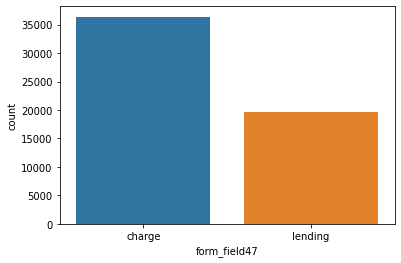

In [ ]:
#countplot of form_field47 feature..
sns.countplot(x='form_field47',data=train)

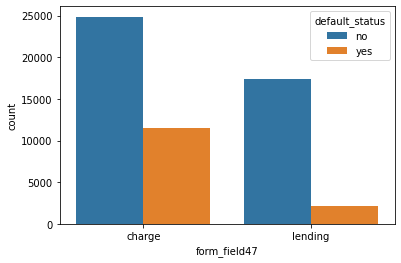

In [ ]:
#frequency distribution of form_field47 variable with respect to the target variable 'default_status'
sns.countplot(x='form_field47',hue='default_status',data=train)

In [ ]:
train['form_field2']

0        0.28505
1        0.67400
2        0.53845
3        0.17005
4        0.77270
          ...   
55995    0.01730
55996    2.01145
55997    0.76640
55998    0.05235
55999    0.46930
Name: form_field2, Length: 56000, dtype: float64

**DEALING WITH MISSING DATA AND DROPPING SOME COLUMNS**

In [35]:
def fill_missing_columns(col):
    for i in col:
        b = -999999
        train[i].fillna(b,inplace=True)
        test[i].fillna(b,inplace= True)
fill_missing_columns(train.drop(["Applicant_ID","default_status"],axis=1))

**ENCODING THE CATEGORICAL VARIABLES,DEFAULT_STATUS**



In [34]:
train.default_status.replace({"yes":1,"no":0},inplace=True)

In [36]:
train.form_field47

0         charge
1         charge
2         charge
3         charge
4         charge
          ...   
55995    lending
55996    lending
55997    lending
55998     charge
55999     charge
Name: form_field47, Length: 56000, dtype: object

**TARGET ENCODE THE CATEGORICAL DATA FORM FIELD 47**

In [45]:
!pip install category_encoders

     |████████████████████████████████| 81kB 2.7MB/s 


In [46]:
from category_encoders import TargetEncoder

In [ ]:
 def transform(self, X, y=None):
        """Perform the target encoding transformation.
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode
            
        Returns
        -------
        pandas DataFrame
            Input DataFrame with transformed columns
        """
        Xo = X.copy()
        for col, tmap in self.maps.items():
            vals = np.full(X.shape[0], np.nan)
            for val, mean_target in tmap.items():
                vals[X[col]==val] = mean_target
            Xo[col] = vals
        return Xo
            

In [50]:
te = TargetEncoder()
a = pd.DataFrame(train.form_field47)
b = pd.DataFrame(test.form_field47)




X_target_encoded = te.fit(a,train["default_status"])
train =X_target_encoded.transform(train)
test = X_target_encoded.transform(test)

ValueError: ignored